In [34]:
using Plots

┌ Info: Precompiling Plots [91a5bcdd-55d7-5caf-9e0b-520d859cae80]
└ @ Base loading.jl:1317


In [43]:
import Base: length

In [27]:
struct OVector{T}
    E::Vector{T}
    val::Vector{T}
    std::Vector{T}
end
OVector(a, b) = OVector(a, b, Float64[])
OVector(a, b, c) = OVector(promote(a,b,c)...)
gauss(x, μ, σ) = 1/(σ*√(2π))*exp(-0.5*((x-μ)/σ)^2)
function OVector(mu::Real, std::Real, size::Int; start=-1.0, stop=1.0)
    E = range(start, stop, length=size) |> collect
    OVector(E, gauss.(E, mu, std))
end

OVector

In [44]:
length(x::OVector) = length(x.E)

length (generic function with 180 methods)

In [2]:
function foo(v::T) where T<:AbstractArray{V} V
    @show v
end

LoadError: UndefVarError: V not defined

In [24]:
mutable struct Omvector{T, TE, V, VE} <: AbstractVector{T}
    E::VE{TE}
    val::V{T}
    std::V{T}
end

LoadError: TypeError: in Type{...} expression, expected UnionAll, got a value of type TypeVar

In [31]:
@macrodebug quote $(Expr(:meta, :inline)) end

In [18]:
v = OVector{Int}(1, 4, 5)

MethodError: MethodError: no method matching size(::OVector{Int64})
[0mClosest candidates are:
[0m  size(::AbstractArray{T, N}, [91m::Any[39m) where {T, N} at abstractarray.jl:38
[0m  size([91m::Union{LinearAlgebra.Adjoint{T, var"#s832"}, LinearAlgebra.Transpose{T, var"#s832"}} where {T, var"#s832"<:(AbstractVector{T} where T)}[39m) at /build/julia/src/julia-1.6.2/usr/share/julia/stdlib/v1.6/LinearAlgebra/src/adjtrans.jl:196
[0m  size([91m::Union{LinearAlgebra.Adjoint{T, var"#s832"}, LinearAlgebra.Transpose{T, var"#s832"}} where {T, var"#s832"<:(AbstractMatrix{T} where T)}[39m) at /build/julia/src/julia-1.6.2/usr/share/julia/stdlib/v1.6/LinearAlgebra/src/adjtrans.jl:197
[0m  ...

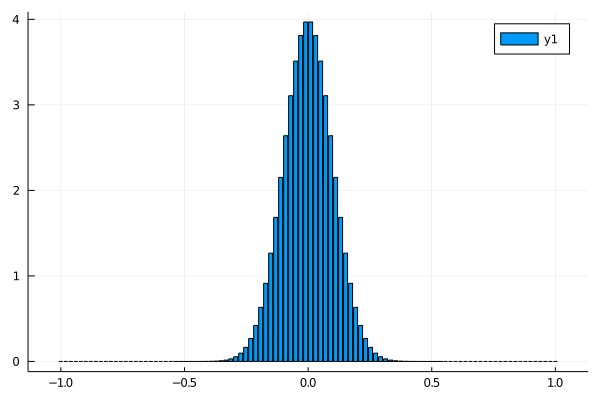

In [109]:
vec = OVector(0.0, 0.1, 100)
bar(vec.E, vec.val)

In [70]:
function rebin(vec::OVector{T}, bins)::OVector{T} where T
    E₀ⁱ = vec.E[1]
    ΔEⁱ = vec.E[2] - vec.E[1]
    E₀ᵒ = bins[1]
    ΔEᵒ = bins[2] - bins[1]
    out = zeros(T, length(bins))
    for i in 1:length(bins)
        x = round(Int, (E₀ᵒ + (i-2)*ΔEᵒ - E₀ⁱ)/ΔEⁱ)
        y = round(Int, (E₀ᵒ + (i)*ΔEᵒ - E₀ⁱ)/ΔEⁱ)
        jmin = max(1, x)
        jmax = min(length(vec), y)
        Eᵒᵢ = E₀ᵒ + ΔEᵒ*(i-1)
        for j in jmin:jmax
            Eⁱⱼ = E₀ⁱ + ΔEⁱ*(j-1)
            η = overlap(Eⁱⱼ, Eⁱⱼ + ΔEⁱ, Eᵒᵢ, Eᵒᵢ + ΔEᵒ)
            out[i] += η*vec.E[j]/ΔEⁱ
        end
    end
    OVector(convert(Vector{Float64}, bins), out)
end

rebin (generic function with 1 method)

In [ ]:
function midtolow(vec)
     |---|--|-|----|--|
end

In [203]:
function overlap(lower_in, upper_in, lower_out, upper_out)
    return max(0.0, min(upper_out, upper_in) - max(lower_in, lower_out))/(upper_in - lower_in)
end

overlap (generic function with 1 method)

In [295]:
⋦(a, b; atol=1e-5) = (a < b) && !isapprox(a, b; atol)

⋦ (generic function with 1 method)

In [296]:
function rebin2(vec::OVector{T}, bins)::OVector{T} where T
    # Assumes equidistant
    # From mid to lower bin
    E = collect(vec.E)
    ΔE = E[2] - E[1] |> abs
    E .-= ΔE/2
    
    B = collect(bins)
    ΔB = B[2] - B[1] |> abs
    B .-= ΔB/2
    # Find first
    start = 0
    for j in 2:length(E)
        if E[j] > B[1]
            start = j-1
            break
        end
    end
    if start == 0
        throw("No overlap between new and old bins")
    end
    
    new = zeros(T, length(bins))
    j = start
    match = false
    for i in 1:length(new)
        println("\nB = $(B[i]) , $(B[i]+ΔB)")
        while j < length(E)
            c = overlap(E[j], E[j]+ΔE, B[i], B[i]+ΔB)
            println("j = $j")
            println("E = $(E[j]) , $(E[j]+ΔE)")
            println("c = $(c)")
            println("c ⋦ $(c ⋦ one(c))")
            new[i] += c*vec.val[j]
            if c ⋦ one(c) && match
                break
            end
            match = true
            j += 1
        end
        match = false
        println("J = $j")
    end
    OVector(bins, new)
end

rebin2 (generic function with 1 method)

In [303]:
rebinned = rebin2(vec, range(-1, 1, length=200) |> collect)


B = -1.0050251256281406 , -0.9949748743718592
j = 1
E = -1.0101010101010102 , -0.98989898989899
c = 0.49748743718593136
c ⋦ true
j = 2
E = -0.9898989898989898 , -0.9696969696969696
c = 0.0
c ⋦ true
J = 2

B = -0.9949748743718593 , -0.9849246231155778
j = 2
E = -0.9898989898989898 , -0.9696969696969696
c = 0.24623115577889426
c ⋦ true
j = 3
E = -0.9696969696969697 , -0.9494949494949495
c = 0.0
c ⋦ true
J = 3

B = -0.9849246231155779 , -0.9748743718592965
j = 3
E = -0.9696969696969697 , -0.9494949494949495
c = 0.0
c ⋦ true
j = 4
E = -0.9494949494949496 , -0.9292929292929294
c = 0.0
c ⋦ true
J = 4

B = -0.9748743718592965 , -0.964824120603015
j = 4
E = -0.9494949494949496 , -0.9292929292929294
c = 0.0
c ⋦ true
j = 5
E = -0.9292929292929293 , -0.9090909090909091
c = 0.0
c ⋦ true
J = 5

B = -0.9648241206030151 , -0.9547738693467337
j = 5
E = -0.9292929292929293 , -0.9090909090909091
c = 0.0
c ⋦ true
j = 6
E = -0.9090909090909092 , -0.888888888888889
c = 0.0
c ⋦ true
J = 6

B = -0.954773869

c = 0.0
c ⋦ true
j = 53
E = 0.040404040404040394 , 0.060606060606060615
c = 0.0
c ⋦ true
J = 53

B = -0.4824120603015076 , -0.4723618090452261
j = 53
E = 0.040404040404040394 , 0.060606060606060615
c = 0.0
c ⋦ true
j = 54
E = 0.060606060606060594 , 0.08080808080808081
c = 0.0
c ⋦ true
J = 54

B = -0.4723618090452262 , -0.4623115577889447
j = 54
E = 0.060606060606060594 , 0.08080808080808081
c = 0.0
c ⋦ true
j = 55
E = 0.0808080808080808 , 0.10101010101010102
c = 0.0
c ⋦ true
J = 55

B = -0.4623115577889447 , -0.4522613065326633
j = 55
E = 0.0808080808080808 , 0.10101010101010102
c = 0.0
c ⋦ true
j = 56
E = 0.101010101010101 , 0.12121212121212122
c = 0.0
c ⋦ true
J = 56

B = -0.45226130653266333 , -0.4422110552763819
j = 56
E = 0.101010101010101 , 0.12121212121212122
c = 0.0
c ⋦ true
j = 57
E = 0.12121212121212122 , 0.14141414141414144
c = 0.0
c ⋦ true
J = 57

B = -0.44221105527638194 , -0.4321608040201005
j = 57
E = 0.12121212121212122 , 0.14141414141414144
c = 0.0
c ⋦ true
j = 58
E = 

J = 100

B = 0.1708542713567839 , 0.18090452261306536
J = 100

B = 0.1809045226130653 , 0.19095477386934676
J = 100

B = 0.1909547738693467 , 0.20100502512562815
J = 100

B = 0.20100502512562812 , 0.21105527638190957
J = 100

B = 0.21105527638190952 , 0.22110552763819097
J = 100

B = 0.22110552763819094 , 0.2311557788944724
J = 100

B = 0.23115577889447234 , 0.2412060301507538
J = 100

B = 0.24120603015075376 , 0.2512562814070352
J = 100

B = 0.25125628140703515 , 0.2613065326633166
J = 100

B = 0.26130653266331655 , 0.271356783919598
J = 100

B = 0.27135678391959794 , 0.2814070351758794
J = 100

B = 0.2814070351758794 , 0.29145728643216084
J = 100

B = 0.2914572864321608 , 0.30150753768844224
J = 100

B = 0.3015075376884422 , 0.31155778894472363
J = 100

B = 0.3115577889447236 , 0.32160804020100503
J = 100

B = 0.32160804020100503 , 0.3316582914572865
J = 100

B = 0.3316582914572864 , 0.3417085427135679
J = 100

B = 0.3417085427135678 , 0.35175879396984927
J = 100

B = 0.3517587939698

OVector{Float64}([-1.0, -0.9899497487437185, -0.9798994974874372, -0.9698492462311558, -0.9597989949748744, -0.949748743718593, -0.9396984924623115, -0.9296482412060302, -0.9195979899497487, -0.9095477386934674  …  0.9095477386934674, 0.9195979899497487, 0.9296482412060302, 0.9396984924623115, 0.949748743718593, 0.9597989949748744, 0.9698492462311558, 0.9798994974874372, 0.9899497487437185, 1.0], [3.8279661509745633e-22, 1.3996818002333706e-21, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0  …  0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], Float64[])

In [304]:
println(sum(vec.val))
println(sum(rebinned.val))

49.500000000000014
1.782478415330827e-21


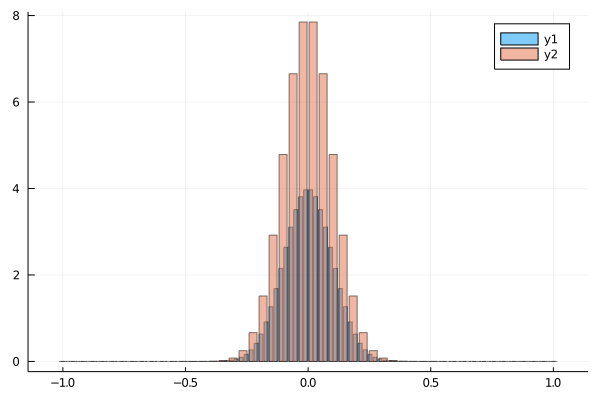

In [302]:
bar(vec.E, vec.val, alpha=0.5)
bar!(rebinned.E, rebinned.val, alpha=0.5)

In [218]:
length(rebinned.E)

10

In [294]:
?isapprox

search: isapprox



```
isapprox(x, y; atol::Real=0, rtol::Real=atol>0 ? 0 : √eps, nans::Bool=false[, norm::Function])
```

Inexact equality comparison: `true` if `norm(x-y) <= max(atol, rtol*max(norm(x), norm(y)))`. The default `atol` is zero and the default `rtol` depends on the types of `x` and `y`. The keyword argument `nans` determines whether or not NaN values are considered equal (defaults to false).

For real or complex floating-point values, if an `atol > 0` is not specified, `rtol` defaults to the square root of [`eps`](@ref) of the type of `x` or `y`, whichever is bigger (least precise). This corresponds to requiring equality of about half of the significand digits. Otherwise, e.g. for integer arguments or if an `atol > 0` is supplied, `rtol` defaults to zero.

The `norm` keyword defaults to `abs` for numeric `(x,y)` and to `LinearAlgebra.norm` for arrays (where an alternative `norm` choice is sometimes useful). When `x` and `y` are arrays, if `norm(x-y)` is not finite (i.e. `±Inf` or `NaN`), the comparison falls back to checking whether all elements of `x` and `y` are approximately equal component-wise.

The binary operator `≈` is equivalent to `isapprox` with the default arguments, and `x ≉ y` is equivalent to `!isapprox(x,y)`.

Note that `x ≈ 0` (i.e., comparing to zero with the default tolerances) is equivalent to `x == 0` since the default `atol` is `0`.  In such cases, you should either supply an appropriate `atol` (or use `norm(x) ≤ atol`) or rearrange your code (e.g. use `x ≈ y` rather than `x - y ≈ 0`).   It is not possible to pick a nonzero `atol` automatically because it depends on the overall scaling (the "units") of your problem: for example, in `x - y ≈ 0`, `atol=1e-9` is an absurdly small tolerance if `x` is the [radius of the Earth](https://en.wikipedia.org/wiki/Earth_radius) in meters, but an absurdly large tolerance if `x` is the [radius of a Hydrogen atom](https://en.wikipedia.org/wiki/Bohr_radius) in meters.

!!! compat "Julia 1.6"
    Passing the `norm` keyword argument when comparing numeric (non-array) arguments requires Julia 1.6 or later.


# Examples

```jldoctest
julia> 0.1 ≈ (0.1 - 1e-10)
true

julia> isapprox(10, 11; atol = 2)
true

julia> isapprox([10.0^9, 1.0], [10.0^9, 2.0])
true

julia> 1e-10 ≈ 0
false

julia> isapprox(1e-10, 0, atol=1e-8)
true
```

---

```
isapprox(x; kwargs...) / ≈(x; kwargs...)
```

Create a function that compares its argument to `x` using `≈`, i.e. a function equivalent to `y -> y ≈ x`.

The keyword arguments supported here are the same as those in the 2-argument `isapprox`.

---

```
isapprox(x::FixedPoint, y::FixedPoint; rtol=0, atol=max(eps(x), eps(y)))
```

For FixedPoint numbers, the default criterion is that `x` and `y` differ by no more than `eps`, the separation between adjacent fixed-point numbers.


In [104]:
i = 0
while (c = 1+i) < 10
    i += 1
end
print(c)

10

In [1]:
a = 1:5

1:5

In [2]:
@which 4 in a

in(x::Integer, r::AbstractUnitRange{var"#s79"} where var"#s79"<:Integer) in Base at range.jl:1090